In [65]:
using DataFrames
using VegaLite

In [223]:
function sum_up_round(x)
    all(0.0 .<= x .<= 1.0) || error("Input must lie in [0, 1]!")
    
    result = zeros(size(x))
    sum = 0.0
    for (index, value) in enumerate(x)
        sum += value
        rounded = round(sum)
        result[index] = rounded
        sum -= rounded
    end

    @assert -1.0 <= sum <= 1.0
    @assert all(0.0 .<= result .<= 1.0)
    
    return result
end

sum_up_round (generic function with 2 methods)

In [211]:
ramp_down(length) = range(1.0, 0.0, length=length)

ramp_down (generic function with 1 method)

In [213]:
sum_up_round(ramp_down(5))

5-element Array{Float64,1}:
 1.0
 1.0
 0.0
 0.0
 0.0

In [227]:
parts = DataFrame[]
for n in 7:7:56
    ramp = collect(ramp_down(n))
    push!(parts, DataFrame(num_days=n, day=1:n, mode="continuous", v=ramp))
    rounded = sum_up_round(ramp)
    push!(parts, DataFrame(num_days=n, day=1:n, mode="binary", v=rounded))
end
data = vcat(parts...)
first(data, 3)

,num_days,day,mode,v
,Int64,Int64,String,Float64
1,7,1,continuous,1.0
2,7,2,continuous,0.833333
3,7,3,continuous,0.666667


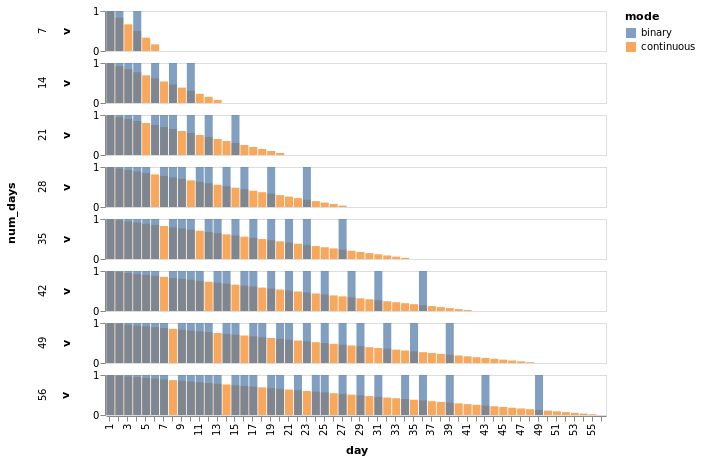

In [228]:
@vlplot(
    mark={:bar, opacity=0.7},
    height=40, width=500, data=data,
    x="day:o", y={:v, stack=nothing}, row="num_days:n", color=:mode
)